In [1]:
import networkx as nx
import numpy as np
from topo import TopoGraph
from collections import defaultdict
import matplotlib.pyplot as plt
from CTCEHC_mst import CTCEHC_part
import random
import glob
from pathlib import Path
import metis
from tqdm.notebook import tqdm
from collections import Counter
from match import *
from crossover import *
import pandas as pd
from time import time

In [2]:
def CV(n, k, labels):
    d = {i: 0 for i in range(k)}
    for i in labels:
        d[i] += 1
    x = n / k
    sigma = np.sqrt(sum((x - x_i) ** 2 for _, x_i in d.items()) / k)
    return sigma / x

In [3]:
def get_topos(path):
    topos = []
    for filepath in glob.glob(path):
        path = Path(filepath)
        G = nx.read_weighted_edgelist(path, nodetype=int)
        for u, v, d in G.edges(data=True):
            if "weight" in d:
                d['bw'] = d['weight']
                del d['weight']
        topos.append(G)
    topos.sort(key=len)
    return topos

In [4]:
servers = get_topos("./graphs/targets/*.wel")
topos_1 = get_topos("./graphs/ipran/*.wel")
topos_2 = get_topos("./graphs/random/*.wel")
topos_3 = get_topos("./graphs/tri/*.wel")
topos_4 = get_topos("./graphs/rlocal/*.wel")

In [71]:
saved_opt = deepcopy(opt)

In [70]:
met = defaultdict(list)
# opt = {}

topos = topos_4

for G in tqdm(topos):
    for S in tqdm(servers):
        N, M = len(G), len(S)

        T = TopoGraph(G)
        labels, _ = T.split_graph(M, part_graph=metis.part_graph)
        cluster_graph = T.get_cluster_graph()

        best_map = random_matching(cluster_graph, S)
        best_K_min = K_MIN(cluster_graph, S, best_map)
        opt[(N, M)] = best_K_min
        for _ in range(1):
            # mmap = isorank(cluster_graph, S, num_iterations=500, alpha=0.1)
            mmap, _ = magna_plus_plus(cluster_graph, S, fitness=fitness_function_k_min, crossover=Crossover.PMX, generations=500, population_size=50)
            met[(N, M)].append(K_MIN(cluster_graph, S, mmap))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [72]:
avg_scores_1 = defaultdict(list)
avg_scores_2 = defaultdict(list)
for (N, M), K_found_list in met.items():
    avg_scores_1[M].append(np.mean(K_found_list))
    avg_scores_2[M].append(saved_opt[(N, M)])

In [73]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, root_mean_squared_log_error

In [75]:
for M in avg_scores_1:
    print(f"{root_mean_squared_log_error(avg_scores_1[M], avg_scores_2[M]):.02f}", sep=";")


0.00
0.00
0.00
0.03
0.17
0.01
0.15
0.08


In [47]:
avg_scores_1

defaultdict(list, {3: []})

In [11]:
magna_params = {
    "fitness": {
        # r"$K_{min}$": fitness_function_k_min,
        r"$K_{degree}$": fitness_function_degree
    },
    "crossover": {name: Crossover.__dict__[name] for name in Crossover.__dict__ if not name.startswith("_")}
}

In [12]:
res_k = {}

for G in tqdm(topos):
    for S in tqdm([i for i in servers if len(i) > 9]):
        N, M = len(G), len(S)
        T = TopoGraph(G)
        labels, _ = T.split_graph(M, part_graph=metis.part_graph)
        cluster_graph = T.get_cluster_graph()

        best_map = random_matching(cluster_graph, S)
        best_K_min = K_MIN(cluster_graph, S, best_map)

        for fit_label, fitness in magna_params["fitness"].items():
            for cros_label, crossover in tqdm(magna_params["crossover"].items()):
                t0 = time()
                mmap, ks = magna_plus_plus(cluster_graph, S, fitness=fitness, crossover=crossover, generations=1000, population_size=50)
                res_k[(N, M, f"{cros_label} | {fit_label}")] = ks, time() - t0, best_K_min
        break
    break
                

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Построение графиков для каждого элемента res_k.items()
for key, data in res_k.items():
    fig, ax = plt.subplots(figsize=(10, 6))  # Создаем новый график для каждого элемента

    K = np.array(data[0])
    Opt = np.array([data[-1]] * len(K))
    X = list(range(len(K)))
    ax.plot(X, Opt, marker='o', linestyle='-', label="optimum", color="black", linewidth=3, markersize=3)
    ax.plot(X, K, marker='o', linestyle='-', color="orange", label=key[-1], markersize=3)

    ax.set_title(r'$K_{min}$ (M = %d)' % key[1])
    ax.set_xlabel('iter')
    ax.set_ylabel(r"$K_{min}$")
    ax.legend(loc=0, prop={'size': 7})
    ax.grid(True)
    # plt.show()  # Показываем график для текущего элемента
    base_path = f"./res/magna-k_degree{key[1]}"
    filename = f"{base_path}_{key}.svg"
    plt.savefig(filename, format='svg')
    plt.close()


In [9]:
best_K_min

9000.0

In [8]:
np.array([1,2,3,4,5]) / np.array([5,5,5,5,5])

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [79]:
def gen_cg(n,p):
    connected_graph = nx.erdos_renyi_graph(n, p)
    while not nx.is_connected(connected_graph):
        connected_graph = nx.erdos_renyi_graph(n, p)
    for edge in connected_graph.edges():
        weight = random.randint(10, 40)
        connected_graph[edge[0]][edge[1]]["bw"] = weight * 50
    return connected_graph

In [80]:
topos = [gen_cg(n, 0.1) for n in range(100, 1001, 100)]

In [83]:
met = dict()
ctc = dict()

for G in tqdm(topos):
    if len(G) not in met:
        met[len(G)] = {
            "M": [],
            "K": []
        }
        ctc[len(G)] = {
            "M": [],
            "K": []
        }
        
    for S in tqdm(servers[:-1]):
        s = len(S)
        T = TopoGraph(G)
        labels_met, _ = T.split_graph(s, part_graph=metis.part_graph)
        cluster_graph = T.get_cluster_graph()
        best_map = random_matching(cluster_graph, S)
        best_K_min = K_MIN(cluster_graph, S, best_map)
        met[len(G)]["M"].append(s)
        met[len(G)]["K"].append(best_K_min)
        
        labels_ctc, _ = T.split_graph(s, part_graph=CTCEHC_part)
        cluster_graph = T.get_cluster_graph()
        try:
            best_map = random_matching(cluster_graph, S)
            best_K_min = K_MIN(cluster_graph, S, best_map)
            ctc[len(G)]["M"].append(s)
            ctc[len(G)]["K"].append(best_K_min)
        except:
            ctc[len(G)]["M"].append(s)
            ctc[len(G)]["K"].append(None)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

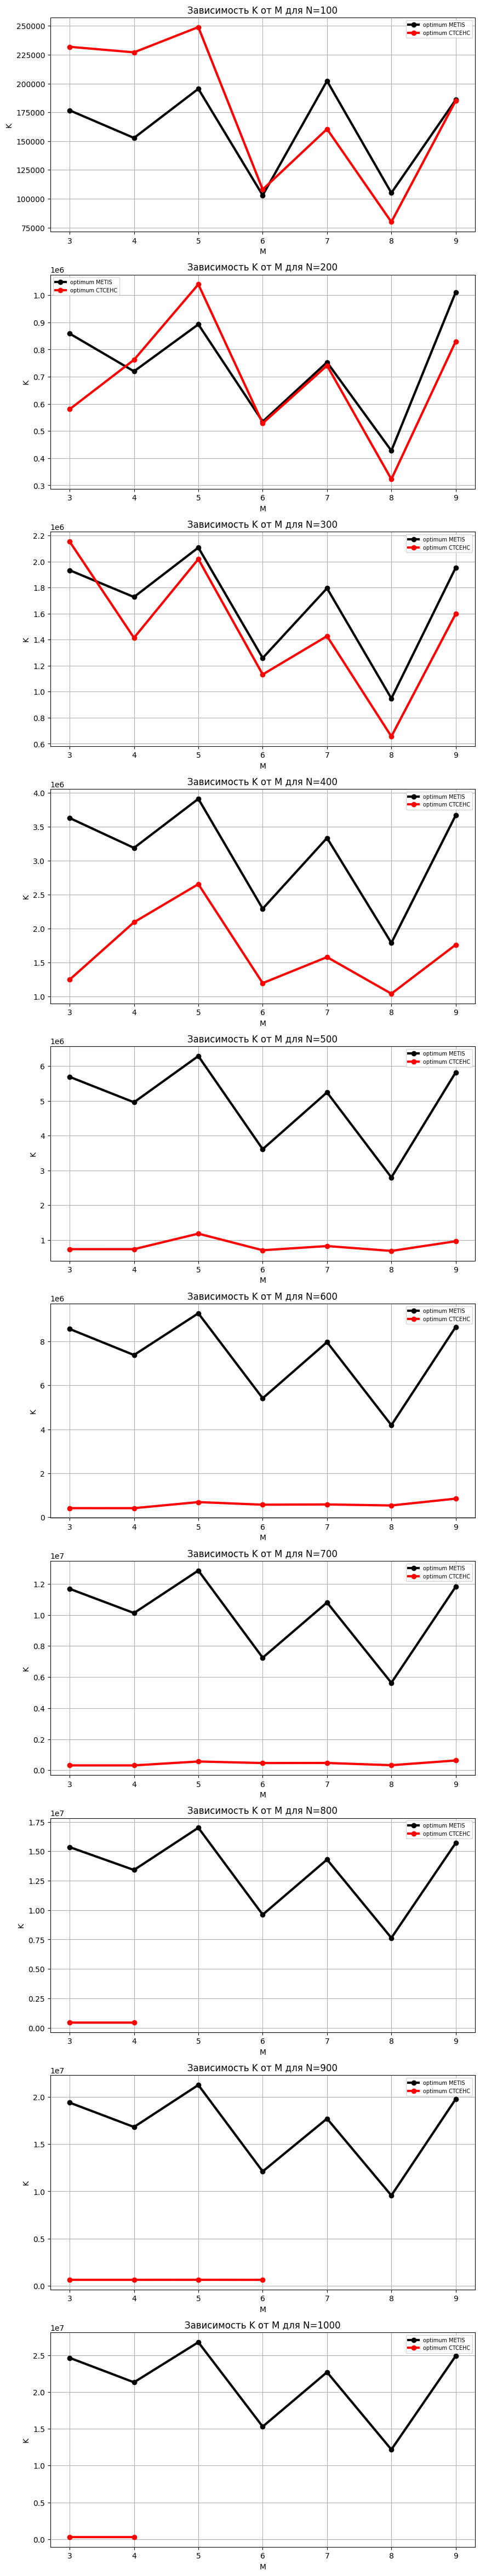

In [94]:
# Построение графиков для всех N
fig, axs = plt.subplots(len(met), figsize=(10, 6 * len(met)))

for ax, key in zip(axs, met):
    M1 = met[key]["M"]
    K1 = met[key]["K"]
    M2 = ctc[key]["M"]
    K2 = ctc[key]["K"]

    ax.plot(M1, K1, marker='o', linestyle='-', label="optimum METIS", color="black", linewidth=3)
    ax.plot(M2, K2, marker='o', linestyle='-', label="optimum CTCEHC", color="red", linewidth=3)
    
    
    ax.set_title(f'Зависимость K от M для N={key}')
    ax.set_xlabel('M')
    ax.set_ylabel('K')
    ax.legend(loc=0, prop={'size': 7})
    ax.grid(True)

# plt.tight_layout()
plt.show()


In [91]:
met[600]

{'M': [3, 4, 5, 6, 7, 8, 9],
 'K': [8568200.0,
  7382100.0,
  9283150.0,
  5412000.0,
  7969650.0,
  4187450.0,
  8661900.0]}

In [92]:
ctc[600]

{'M': [3, 4, 5, 6, 7, 8, 9],
 'K': [408200.0, 407950.0, 683900.0, 565350.0, 577300.0, 530300.0, 841550.0]}

In [85]:
m = np.zeros(len(range(5,21)))
for n in met:
    m += met[n]["K"]
m = m / len(met)

c = np.zeros(len(range(5,21)))
l = 0
for n in list(ctc.keys()):
    c += ctc[n]["K"]
c = c / len(ctc)

ValueError: operands could not be broadcast together with shapes (16,) (7,) (16,) 

NameError: name 'c' is not defined

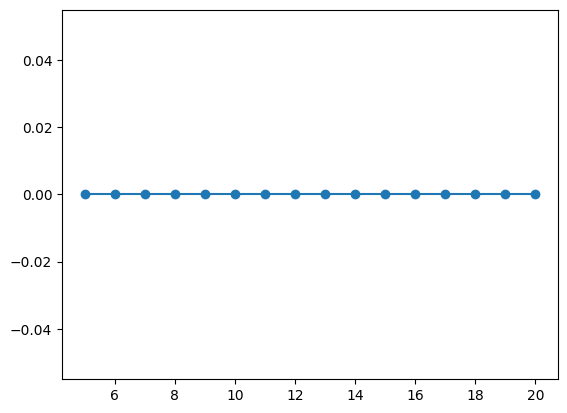

In [86]:
plt.plot(range(5,21), m, label="METIS", marker='o')
plt.plot(range(5,21), c, label="CTCEHC", marker='s')
plt.plot(range(5,21), [0.33]*len(range(5,21)), linestyle="--", color="red", label="0.33")
plt.xlim(5, 20)
# plt.title(r'Средние значения $K_{size}$ в зависимости от M')
plt.xlabel('M')
plt.ylabel(r'Среднее значение $K_{size}$')
plt.legend(loc=0, prop={'size': 7})
plt.grid(True)
plt.savefig("metis_vs_ctcehc.png", format='png')
plt.close()
# plt.show()

In [87]:
met

{100: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [176700.0, 152750.0, 195400.0, 103000.0, 202250.0, 105050.0, 185850.0]},
 200: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [858850.0,
   719850.0,
   892750.0,
   534850.0,
   753350.0,
   427500.0,
   1011350.0]},
 300: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [1933300.0,
   1727600.0,
   2107550.0,
   1258650.0,
   1795050.0,
   948200.0,
   1953200.0]},
 400: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [3630150.0,
   3190050.0,
   3913250.0,
   2294300.0,
   3336550.0,
   1790750.0,
   3670800.0]},
 500: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [5689200.0,
   4958700.0,
   6287500.0,
   3611100.0,
   5243350.0,
   2799300.0,
   5819150.0]},
 600: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [8568200.0,
   7382100.0,
   9283150.0,
   5412000.0,
   7969650.0,
   4187450.0,
   8661900.0]},
 700: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [11678200.0,
   10120350.0,
   12857350.0,
   7245550.0,
   10798800.0,
   5628400.0,
   11816450.0]},
 800: {'M': [3, 4, 5, 6, 7, 8, 9],
  'K': [1535